In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
from cuml import ForestInference
import sys
from tqdm import tqdm
import os
import random
from glob import glob
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric

In [2]:
config = f"""
execution:
    exp_id: exp_003
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    10min_csv_dir: /kaggle/input/save_10min_csvs/pred_10min_csvs

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

## 特徴生成

In [3]:
def generate_features(train: pd.DataFrame):
    features = {}
    if train.shape[0] == 0:
        return train, features
    
    # not for pred
    features["series_id"] = train["series_id"].values[0]
    features["step_min"] = train["step"].min()
    features["step_max"] = train["step"].max()
    if "target" in train.columns:
        features["target"] = train["target"].mean() > 0.5 

    # features
    timestamp = pd.to_datetime(train["timestamp"].values[0])
    features["total_seconds"] = (timestamp - timestamp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()

    # センサのラグ特徴量
    dts = [-10, -5, -3, -1, 1, 3, 5, 10]
    columns = ["anglez", "enmo"]
    lag_names = []
    for dt in dts:            
        f_names = [f"{c}_diff_{dt}" for c in columns]
        train[f_names] = train[columns].diff(dt)
        lag_names.extend(f_names)

    # センサの統計量
    for c in ["anglez", "enmo"] + lag_names:
        features[f"{c}_mean"] = train[c].mean()
        features[f"{c}_median"] = train[c].median()
        features[f"{c}_max"] = train[c].max()
        features[f"{c}_min"] = train[c].min()
        features[f"{c}_std"] = train[c].std()
        features[f"{c}_square_mean"] = (train[c] ** 2).mean()

    return train, features

def read_and_generate_features(file):
    train = pd.read_csv(file)
    train, features = generate_features(train)
    return features

In [4]:
files = glob(f"{CFG['dataset']['10min_csv_dir']}/*/*.csv")

if CFG["execution"]["multiprocessing"]:
    with Pool(30) as pool:
        all_features = list(tqdm(pool.imap(read_and_generate_features, files), total=len(files)))
else:
    all_features = []
    for file in tqdm(files):
        train = pd.read_csv(file)
        train, features = generate_features(train)
        all_features.append(features)

features = set().union(*[d.keys() for d in all_features]) - {"series_id", "step_min", "step_max", "target"}
train = pd.DataFrame(all_features)

100%|██████████| 1066362/1066362 [12:20<00:00, 1439.62it/s]


## 学習

In [5]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train = train.merge(cv_split, on=["series_id"], how="left")
train.head(5)

,series_id,step_min,step_max,target,total_seconds,anglez_mean,anglez_median,anglez_max,anglez_min,anglez_std,...,anglez_diff_10_min,anglez_diff_10_std,anglez_diff_10_square_mean,enmo_diff_10_mean,enmo_diff_10_median,enmo_diff_10_max,enmo_diff_10_min,enmo_diff_10_std,enmo_diff_10_square_mean,fold
0,612aa8ba44e2,268740,268859,True,14400.0,-47.146022,-47.83980,-37.3546,-48.5107,1.948389,...,-10.8115,1.877130,3.687653,0.000051,-0.0001,0.1001,-0.0982,0.014828,2.178713e-04,3
1,612aa8ba44e2,154020,154139,True,45600.0,-86.943919,-86.95065,-86.8061,-87.0715,0.087503,...,-0.2355,0.117368,0.013933,-0.000057,-0.0001,0.0003,-0.0005,0.000140,2.281818e-08,3
2,612aa8ba44e2,371100,371219,True,7800.0,-10.059685,-12.43370,1.2050,-20.6778,5.976369,...,-6.8272,4.305970,18.724655,-0.000260,-0.0003,0.0148,-0.0167,0.004720,2.213964e-05,3
3,612aa8ba44e2,391860,391979,True,25200.0,0.812441,1.23605,8.0100,-10.5224,4.125580,...,-16.0061,5.500844,30.735235,-0.000083,0.0003,0.0092,-0.0097,0.003382,1.134118e-05,3
4,612aa8ba44e2,153300,153419,True,42000.0,-87.034232,-87.03300,-87.0330,-87.0448,0.002442,...,-0.0118,0.003243,0.000010,0.000008,0.0000,0.0003,-0.0002,0.000090,8.090909e-09,3


In [6]:
if CFG['execution']['submit']:
    # 推論
    models = [
        ForestInference.load(
            os.path.join(CFG["model_dir"], f'xgb_fold{i}.model'),
            output_class=True,
            model_type='xgboost'
        ) for i in range(CFG.n_fold)]
    pred = inference_xgb(models, train[features])
else:
    # 学習
    trn_oof, models = fit_xgb(train[features], train["target"], train["fold"].astype(
        int), params=CFG["xgboost"], es_rounds=50)
    train["oof"] = trn_oof

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-logloss:0.62636
[50]	eval-logloss:0.17919
[100]	eval-logloss:0.16941
[150]	eval-logloss:0.16728
[200]	eval-logloss:0.16612
[250]	eval-logloss:0.16567
[300]	eval-logloss:0.16564
[350]	eval-logloss:0.16580
[352]	eval-logloss:0.16581


 20%|██        | 1/5 [01:22<05:28, 82.08s/it]

== fold 1 ==
[0]	eval-logloss:0.62710
[50]	eval-logloss:0.17719
[100]	eval-logloss:0.16440
[150]	eval-logloss:0.15938
[200]	eval-logloss:0.15720
[250]	eval-logloss:0.15566
[300]	eval-logloss:0.15499
[350]	eval-logloss:0.15446
[400]	eval-logloss:0.15401
[450]	eval-logloss:0.15388
[500]	eval-logloss:0.15371
[550]	eval-logloss:0.15368
[600]	eval-logloss:0.15357
[650]	eval-logloss:0.15345
[700]	eval-logloss:0.15337
[738]	eval-logloss:0.15349


 40%|████      | 2/5 [04:14<06:44, 134.95s/it]

== fold 2 ==
[0]	eval-logloss:0.62632
[50]	eval-logloss:0.16532
[100]	eval-logloss:0.15032
[150]	eval-logloss:0.14646
[200]	eval-logloss:0.14401
[250]	eval-logloss:0.14263
[300]	eval-logloss:0.14187
[350]	eval-logloss:0.14133
[400]	eval-logloss:0.14052
[450]	eval-logloss:0.14029
[500]	eval-logloss:0.14013
[550]	eval-logloss:0.14006
[600]	eval-logloss:0.13991
[627]	eval-logloss:0.14002


 60%|██████    | 3/5 [06:39<04:39, 139.88s/it]

== fold 3 ==
[0]	eval-logloss:0.62740
[50]	eval-logloss:0.21326
[100]	eval-logloss:0.20746
[150]	eval-logloss:0.20478
[200]	eval-logloss:0.20351
[250]	eval-logloss:0.20205
[300]	eval-logloss:0.20162
[342]	eval-logloss:0.20170


 80%|████████  | 4/5 [08:00<01:56, 116.65s/it]

== fold 4 ==
[0]	eval-logloss:0.62764
[50]	eval-logloss:0.23500
[100]	eval-logloss:0.23013
[150]	eval-logloss:0.22745
[200]	eval-logloss:0.22632
[250]	eval-logloss:0.22512
[300]	eval-logloss:0.22463
[350]	eval-logloss:0.22444
[400]	eval-logloss:0.22441
[425]	eval-logloss:0.22445


100%|██████████| 5/5 [09:40<00:00, 116.18s/it]


In [7]:
train = train.drop(columns=features)

In [8]:
train

,series_id,step_min,step_max,target,fold,oof
0,612aa8ba44e2,268740,268859,True,3,0.187380
1,612aa8ba44e2,154020,154139,True,3,0.972977
2,612aa8ba44e2,371100,371219,True,3,0.995585
3,612aa8ba44e2,391860,391979,True,3,0.997041
4,612aa8ba44e2,153300,153419,True,3,0.968001
...,...,...,...,...,...,...
1066357,702bb5387b1e,359820,359939,False,2,0.042031
1066358,702bb5387b1e,63420,63539,False,2,0.097294
1066359,702bb5387b1e,221340,221459,True,2,0.854294
1066360,702bb5387b1e,62100,62219,False,2,0.193274


In [9]:
train = train.sort_values(["series_id", "step_min"]).reset_index(drop=True)

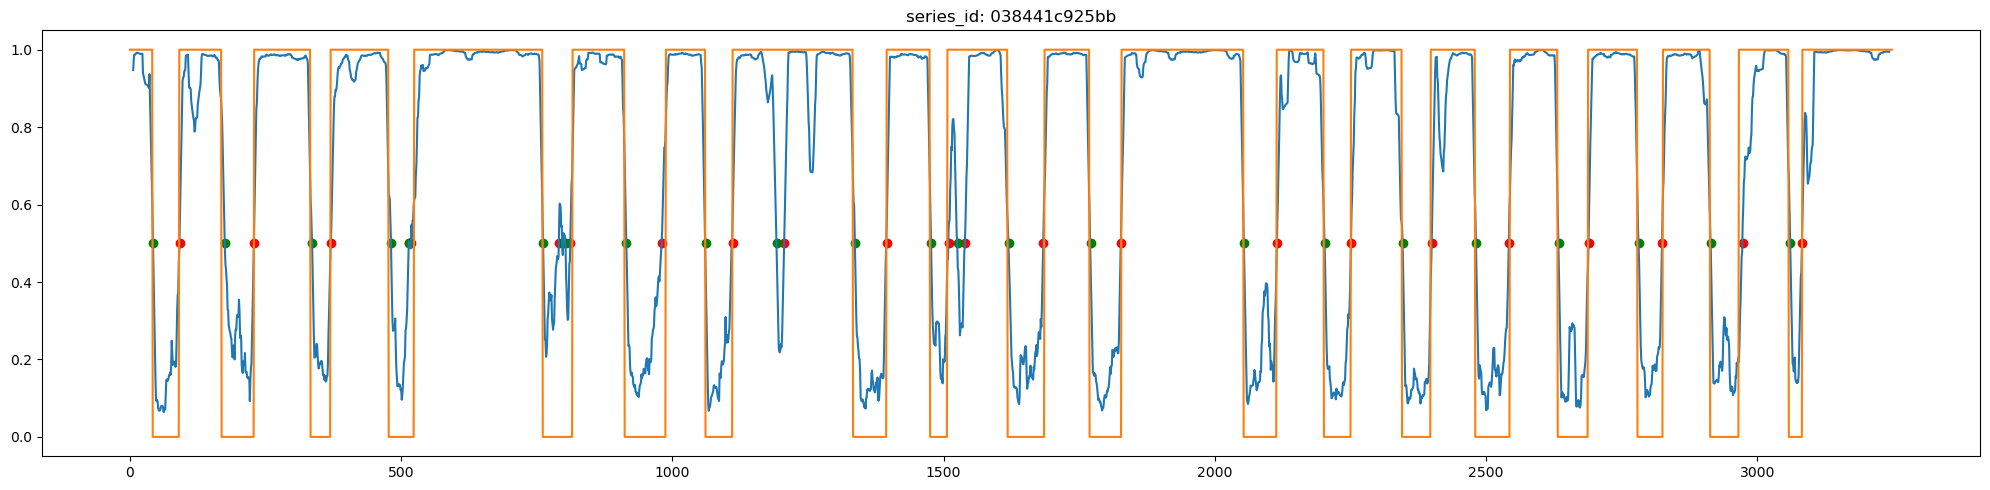

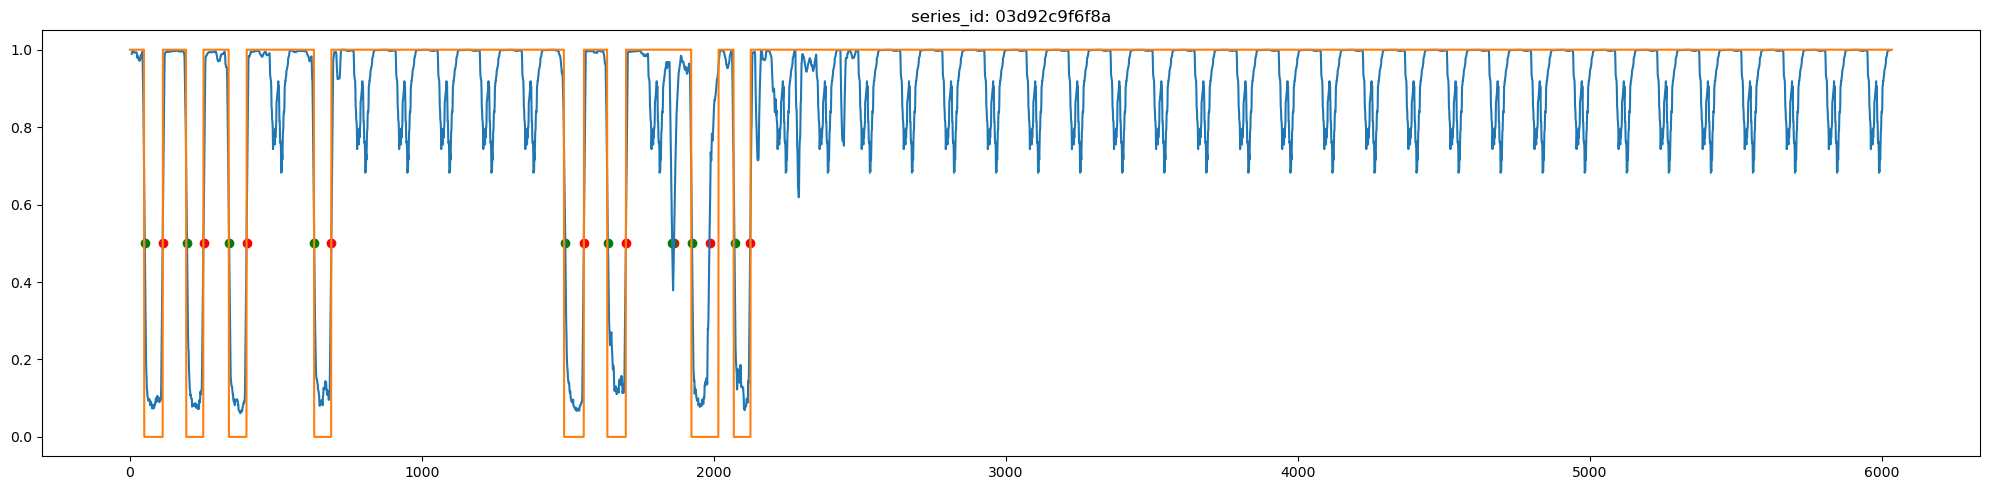

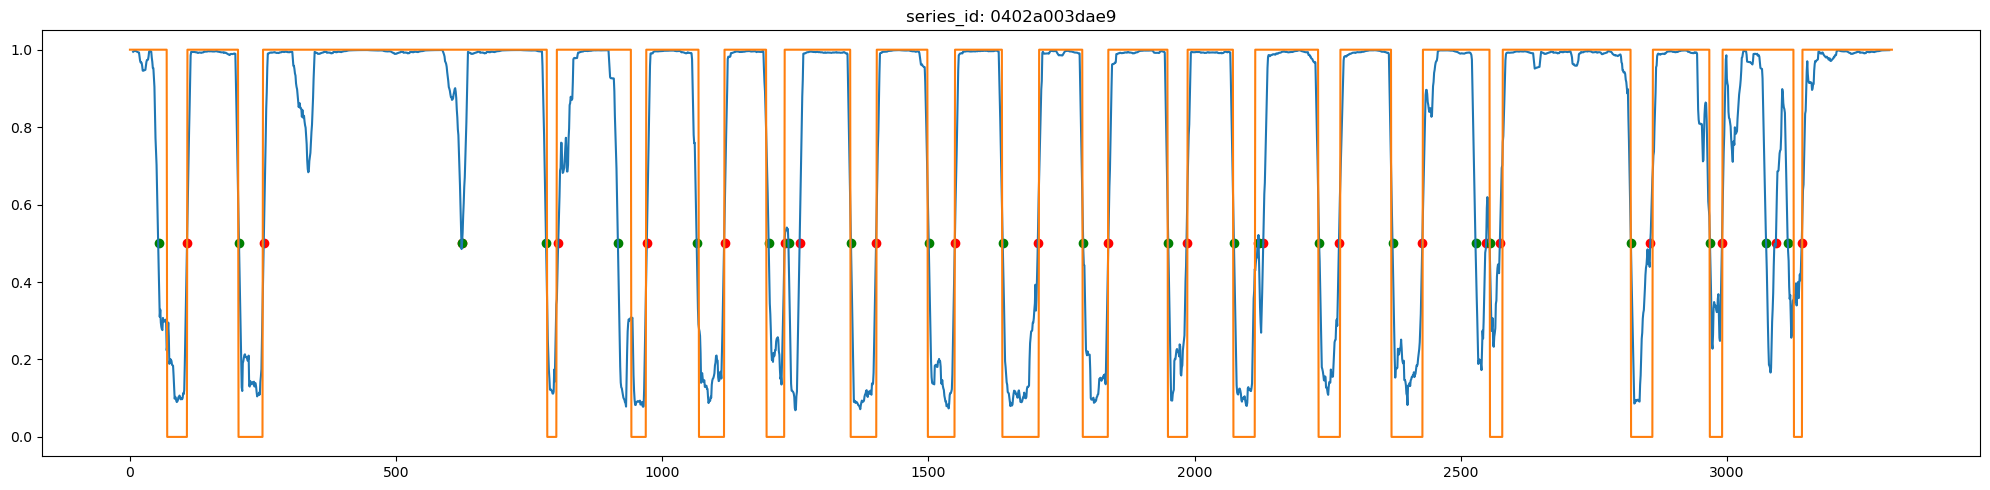

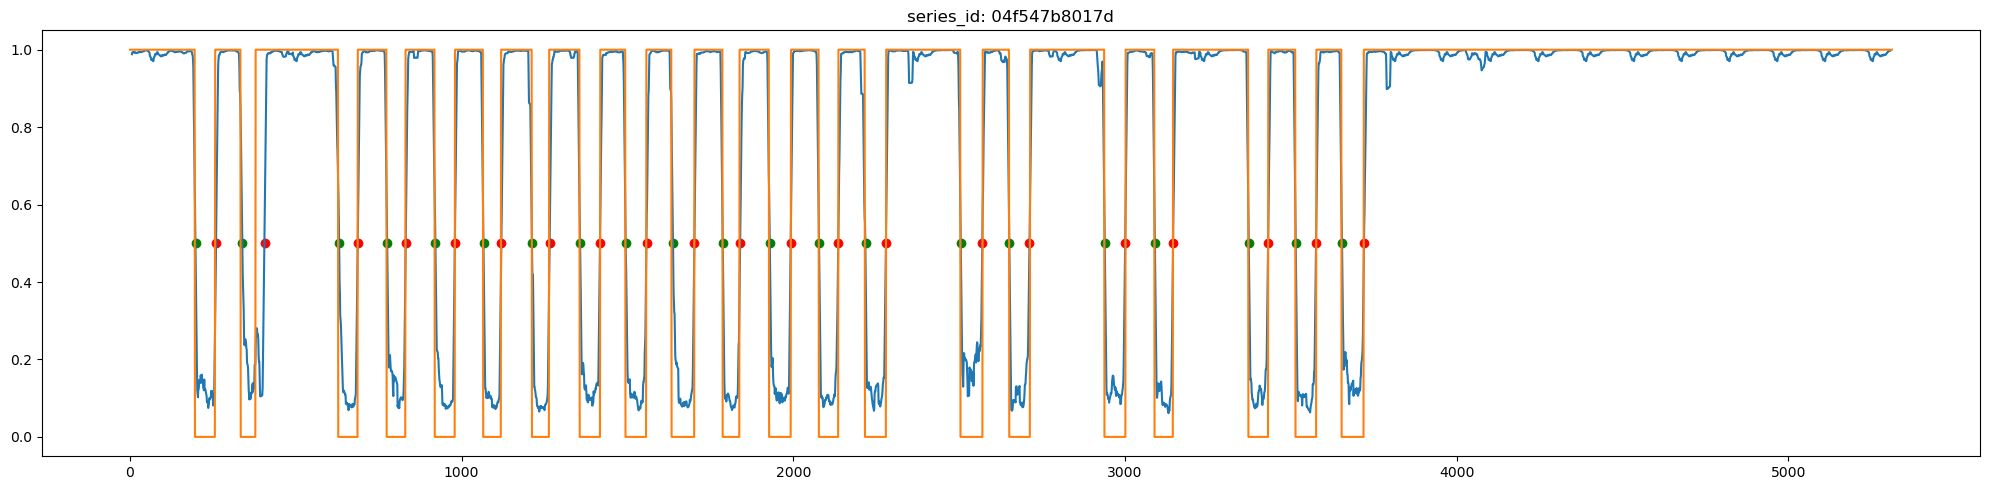

,series_id,step,event,score
0,038441c925bb,11099,wakeup,1
1,038441c925bb,27539,wakeup,1
2,038441c925bb,44579,wakeup,1
3,038441c925bb,61739,wakeup,1
4,038441c925bb,61979,wakeup,1


In [10]:
dfs = []
for series_id, df in train.groupby("series_id"):
    df = df.reset_index(drop=True)
    oof = df["oof"].rolling(12, center=True).mean()
    wakeup_index = [i for i in range(1, len(oof)) if oof[i-1] < 0.5 and oof[i] >= 0.5]
    onset_index = [i for i in range(1, len(oof)) if oof[i-1] > 0.5 and oof[i] <= 0.5]

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "step": (df["step_min"].values[wakeup_index] + df["step_max"].values[wakeup_index]) // 2,
            "event": "wakeup",
            "score": 1,
        }),
        pd.DataFrame({
            "series_id": series_id,
            "step": (df["step_min"].values[onset_index] + df["step_max"].values[onset_index]) // 2,
            "event": "onset",
            "score": 1,
        }),
    ])
    dfs.append(sub)

    if len(dfs) < 5:
        plt.subplots(figsize=(20, 5))
        plt.plot(oof)
        plt.plot(df["target"])
        plt.scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        plt.scatter(onset_index, [0.5 for _ in onset_index], c="green")
        plt.title(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()

sub = pd.concat(dfs).reset_index(drop=True)
sub.head()

In [11]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()

score, ap_table = compute_comptetition_metric(labels, sub)
score

0.20933254070599963

In [12]:
ap_table

event   tolerance
onset   12           0.000109
        36           0.001561
        60           0.005266
        90           0.013737
        120          0.034868
        150          0.056562
        180          0.112282
        240          0.242803
        300          0.367424
        360          0.470250
wakeup  12           0.002056
        36           0.029199
        60           0.083074
        90           0.152062
        120          0.250060
        150          0.320325
        180          0.392566
        240          0.488518
        300          0.555087
        360          0.608843
dtype: float64

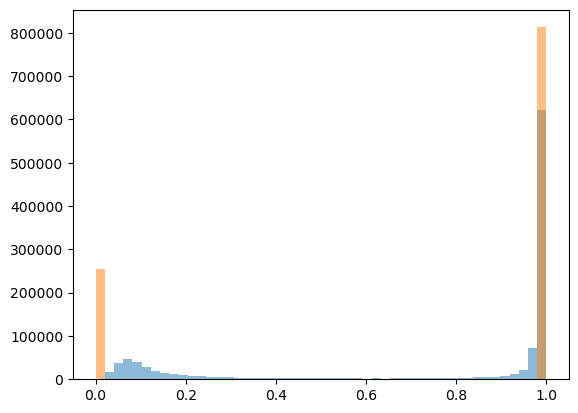

In [13]:
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()